# FTSE 100 Volatility Analysis Using Library

This notebook demonstrates how to use the volatility analysis library to analyze FTSE 100 market volatility in relation to news sentiment.

In [80]:
import sys
import os

# Add the path to the volatility_analysis directory
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(project_root)
sys.path.append(os.path.join(project_root, 'code', 'volatility_analysis'))

# Import the volatility analysis library directly
from volatility_lib import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import yfinance

In [81]:
# Configuration parameters
FETCH_DATA = False  # Set to True to fetch new news data
FROM = "2024-01-01"
TO = "2025-12-31"
CUT = "2024-10-01"  # Date to split train/test data
TOPIC = "BUSINESS"
MARKET_NAME = "FTSE 100"

In [82]:
# FTSE 100 search keywords
ftse_top_20 = [
    "FTSE",  # FTSE 100
    "Bank of England",  # Central bank
    "Interest rates",  # Monetary policy
    "Inflation",  # Inflation
    "GDP",  # Gross Domestic Product
    "Economic growth",  # Growth
    "Economic crisis",  # Crisis
    "Recession",  # Recession
    "Economic recovery",  # Recovery
    "Stock market",  # Stock market
    "Investment",  # Investment
    "Equities",  # Equities
    "Fixed income",  # Fixed income
    "Bonds",  # Bonds
    "London Stock Exchange",  # LSE
    "FTSE 100 companies",  # FTSE 100 companies
    "UK economy",  # UK economy
    "Unemployment",  # Unemployment
    "Sterling",  # British Pound
    "Brexit",  # Brexit
]

In [83]:
# Fetch news data function
def fetch_ftse_news_data():
    from pygooglenews import GoogleNews
    
    # Helper function to convert news to DataFrame
    def convert_to_dataframe(news):
        data = []
        for article in news['entries']:
            try:
                # Try the original format first
                date = datetime.strptime(article['published'], '%a, %d %b %Y %H:%M:%S %Z')
            except ValueError:
                # If that fails, use pd.to_datetime which is more flexible
                date = pd.to_datetime(article['published'])
                # Convert timezone-aware datetime to timezone-naive
                if date.tzinfo is not None:
                    date = date.replace(tzinfo=None)
            title = article['title']
            data.append({'date': date, 'title': title})
        return pd.DataFrame(data)
    
    # Create Google News instance
    gn = GoogleNews(lang="en", country="GB")
    
    # Search for news with the keywords
    news = gn.search(
        query=" OR ".join(ftse_top_20),
        from_=FROM,
        to_=TO,
    )
    
    # Convert to DataFrame
    df = convert_to_dataframe(news)
    df['date'] = pd.to_datetime(df['date'])
    
    # Save to CSV
    os.makedirs("../news", exist_ok=True)
    df.to_csv(f"../news/news_data_{FROM}_{TO}_FTSE.csv", index=False)
    
    return df

In [84]:
# Fetch or load news data
if FETCH_DATA:
    news_df = fetch_ftse_news_data()
    print(f"Fetched {len(news_df)} news articles")
else:
    # Read the CSV file
    news_df = pd.read_csv(f"../news/news_data_{FROM}_{TO}_FTSE.csv", parse_dates=['date'])
    print(f"Loaded {len(news_df)} news articles")

Loaded 100 news articles


In [85]:
# Fetch FTSE 100 market data using yfinance
ftse100 = yfinance.Ticker("^FTSE")
ftse100_data = ftse100.history(start=FROM, end=TO, interval="1d", auto_adjust=True)
ftse100_data = ftse100_data.reset_index()  # Convert index to column
ftse100_data = ftse100_data[["Date", "Close"]].copy()
ftse100_data["Returns"] = ftse100_data["Close"].pct_change()
ftse100_data["Volatility"] = ftse100_data["Returns"].rolling(window=21).std() * np.sqrt(252)
ftse100_data = ftse100_data.dropna().reset_index(drop=True)

print(f"Loaded {len(ftse100_data)} days of FTSE 100 market data")
ftse100_data.head()

Loaded 329 days of FTSE 100 market data


,Date,Close,Returns,Volatility
0,2024-01-31 00:00:00+00:00,7630.600098,-0.004657,0.098211
1,2024-02-01 00:00:00+00:00,7622.200195,-0.001101,0.096856
2,2024-02-02 00:00:00+00:00,7615.500000,-0.000879,0.094640
3,2024-02-05 00:00:00+00:00,7612.899902,-0.000341,0.093687
4,2024-02-06 00:00:00+00:00,7681.000000,0.008945,0.099177


Calculating sentiment scores...


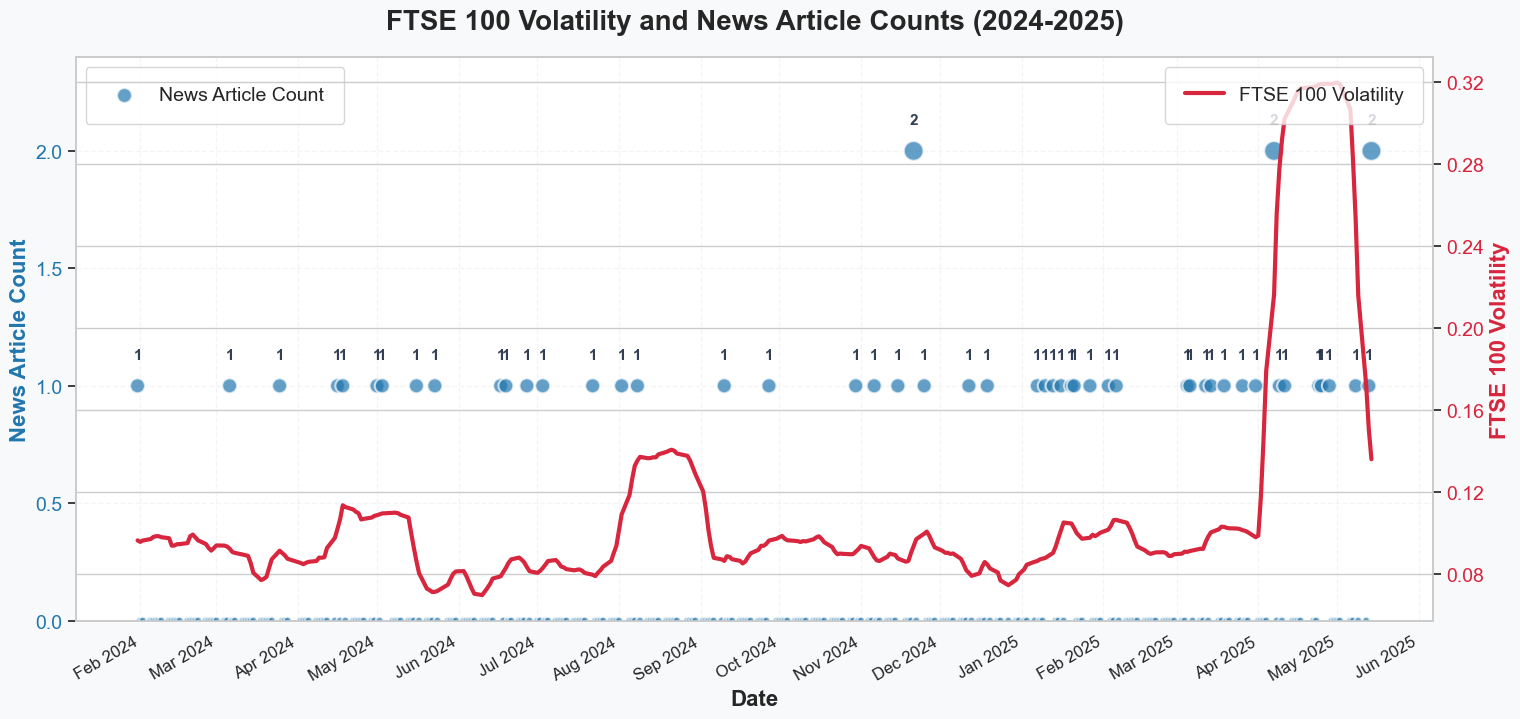

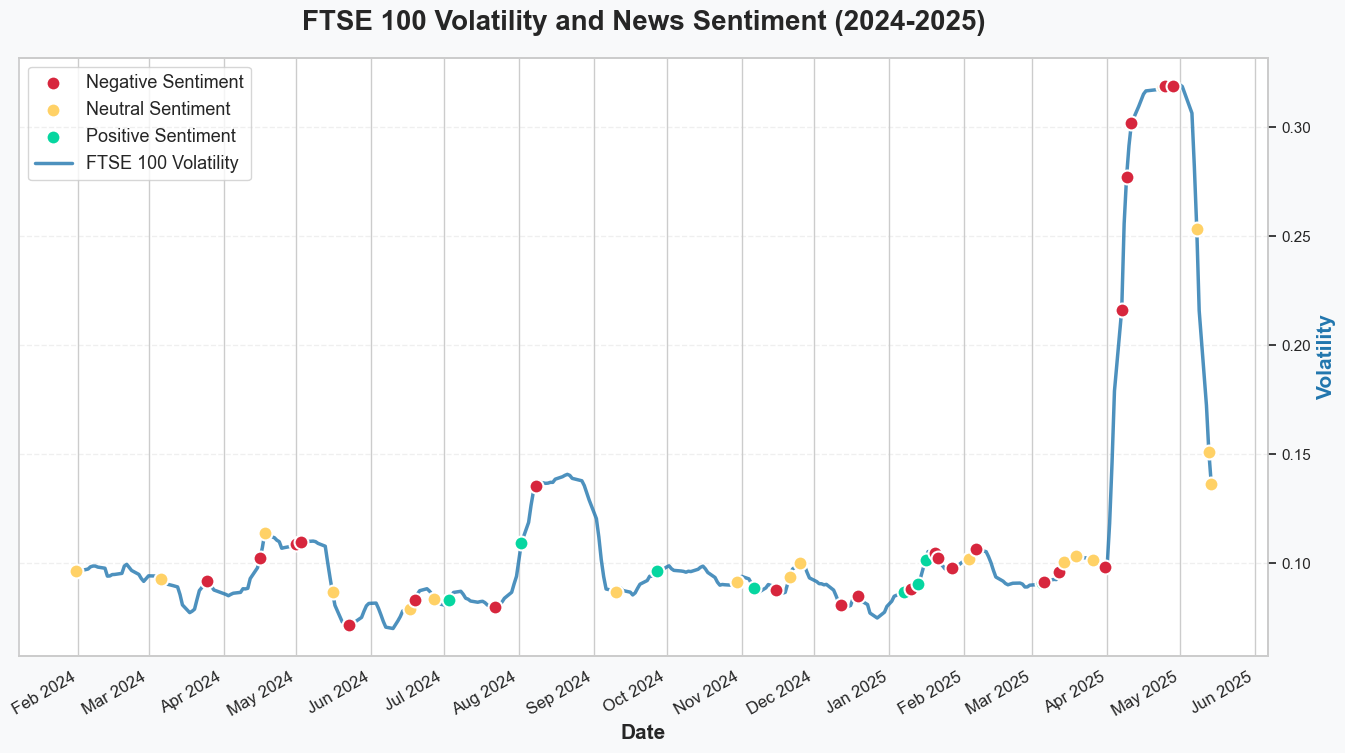

Splitting data at 2024-10-01...
Preparing data for LSTM model...
Training LSTM model with 50 epochs...
Epoch 1/50, Loss: 0.15817
Epoch 10/50, Loss: 0.01974
Epoch 20/50, Loss: 0.00637
Epoch 30/50, Loss: 0.00513
Epoch 40/50, Loss: 0.00302
Epoch 50/50, Loss: 0.00184
Evaluating LSTM model...
Model Performance Metrics:
MSE: 0.001227
RMSE: 0.035026
MAE: 0.015817
R² Score: 0.776873


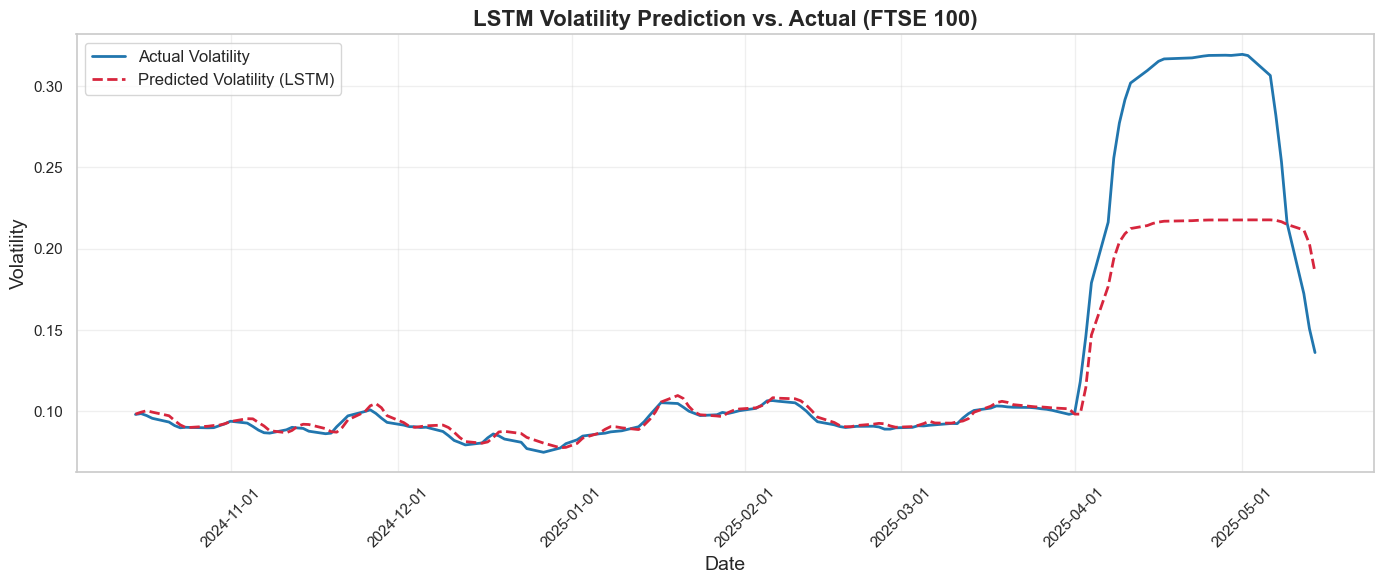

In [86]:
# Run the volatility analysis pipeline
results = run_volatility_pipeline(
    news_df=news_df,
    stock_data=ftse100_data,
    market_name=MARKET_NAME,
    cut_date=CUT,
    output_dir="../news",
    seq_len=10,
    epochs=50,
    batch_size=16,
    learning_rate=0.001,
    verbose=True
)

In [87]:
# Display model metrics
metrics = results['metrics']
for metric_name, value in metrics.items():
    print(f"{metric_name}: {value:.6f}")

MSE: 0.001227
RMSE: 0.035026
MAE: 0.015817
R2: 0.776873


## Custom Analysis (Optional)

You can also use the library functions individually for custom analysis.

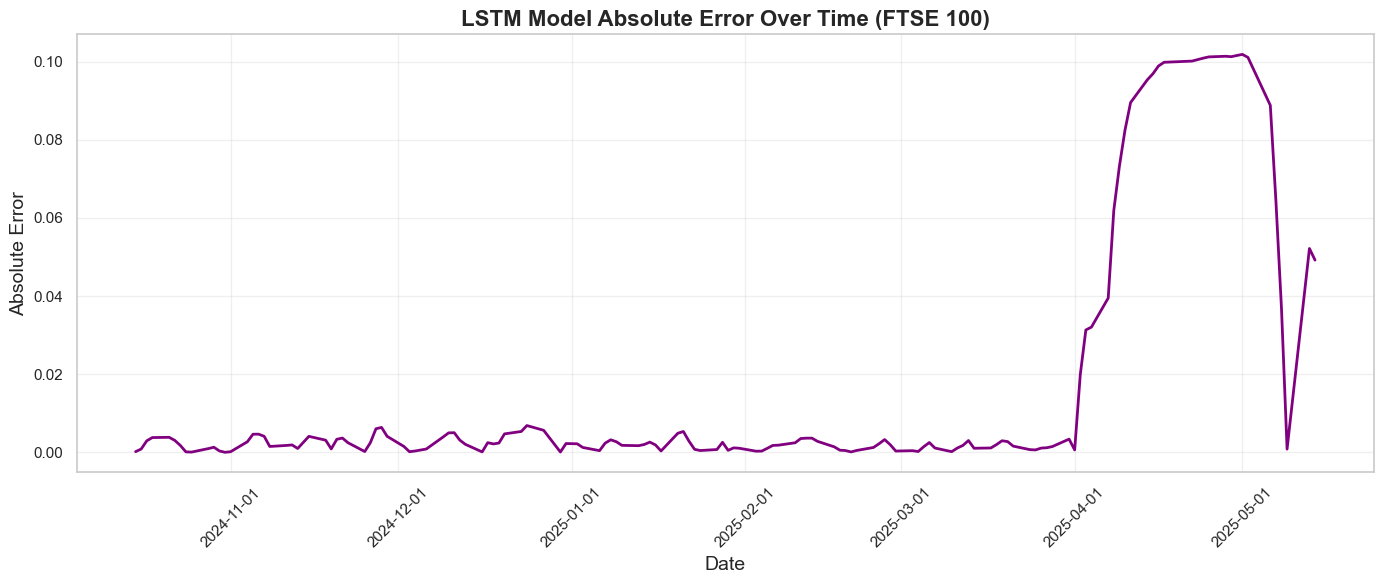

In [88]:
# Example: Creating a custom visualization of the model error over time
error = np.abs(results['y_actual'] - results['y_pred'])
plt.figure(figsize=(14, 6))
plt.plot(results['test_dates'], error, color='purple', linewidth=2)
plt.title('LSTM Model Absolute Error Over Time (FTSE 100)', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Absolute Error', fontsize=14)
plt.grid(True, alpha=0.3)
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../news/ftse100_error_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

## Conclusion

We've successfully analyzed FTSE 100 volatility in relation to news sentiment using our reusable volatility analysis library.
The library provides functions for:

1. Sentiment analysis of financial news
2. Data preparation and LSTM model training
3. Volatility prediction and evaluation
4. Visualization of results

This approach can be applied to other market indices as well.